# 第14章 聚类方法

#### 聚类是针对给定的样本，依据它们属性的相似度或距离，将其归并到若干个“类”或“簇”的数据分析问题。

#### 距离或相似度度量在聚类中起着重要作用。
- 距离度量有闵可夫斯基距离，包括欧氏距离曼哈顿距离、切比雪夫距离、以及马哈拉诺比斯距离
- 相似度度量有相关系数、夹角余弦
- 用距离度量相似度时，距离越小表示样本越相似；用相关系数时，相关系数越大表示样本越相似

#### 类是样本的子集，比如有如下基本定义：
用$G$表示类或簇，用$x_i$,$x_j$；等表示类中的样本，用$d_{ij}$表示样本$x_i$与样本$x_j$之间的距离。如果对任意的$x _ { i } , x _ { j } \in G$，有$$d _ { i j } \leq T$$
则称$G$为一个类或簇。
描述类的特征的指标有中心、直径、散布矩阵、协方差矩阵。

#### 聚合聚类需要预先确定下面三个要素：
- 距离或相似度；
- 合并规则；
- 停止条件。

#### $k$均值聚类是常用的聚类算法
- 基于划分的聚类方法；类别数k事先指定；
- 以欧氏距离平方表示样本之间的距离或相似度，以中心或样本的均值表示类别；
- 以样本和其所属类的中心之间的距离的总和为优化的目标函数；
- 得到的类别是平坦的、非层次化的；
- 算法是迭代算法，不能保证得到全局最优。

#### $k$均值聚类算法
- 首先选择 k 个类的中心，将样本分到与中心最近的类中，得到一个聚类结果；
- 然后计算每个类的样本的均值，作为类的新的中心；
- 重复以上步骤，直到收敛为止。

In [1]:
import math
import random
import numpy as np 
from sklearn import datasets,cluster
import matplotlib.pyplot as plt
%matplotlib inline

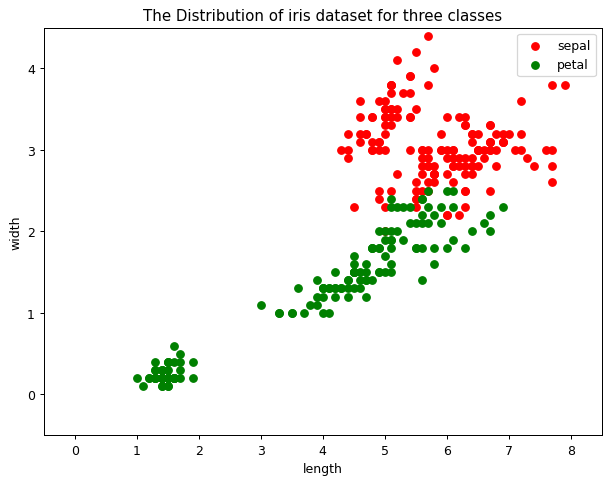

In [37]:
iris = datasets.load_iris()
labels = iris["target"]
data_sepal = iris["data"][:, :2]
data_petal = iris["data"][:, 2:5]
# sepal length（花萼长度） sepal width（花萼宽度）
# petal length（花瓣长度） petal width（花瓣宽度）
sepal_length = data_sepal[:, 0]
sepal_width = data_sepal[:, 1]
petal_length = data_petal[:, 0]
petal_width = data_petal[:, 1]
# visualization
plt.figure(figsize=(8,6), dpi=90)
plt.scatter(sepal_length, sepal_width, color='red', label="sepal")
plt.scatter(petal_length, petal_width, color='green', label="petal")
plt.title("The Distribution of iris dataset for three classes")
plt.xlabel("length")
plt.ylabel("width")
plt.xlim(-0.5, 8.5)
plt.ylim(-0.5, 4.5)
plt.legend()
plt.show()

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 2 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0 1 0 0 1 2 1 0 1 0
 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
---------------------------------------------


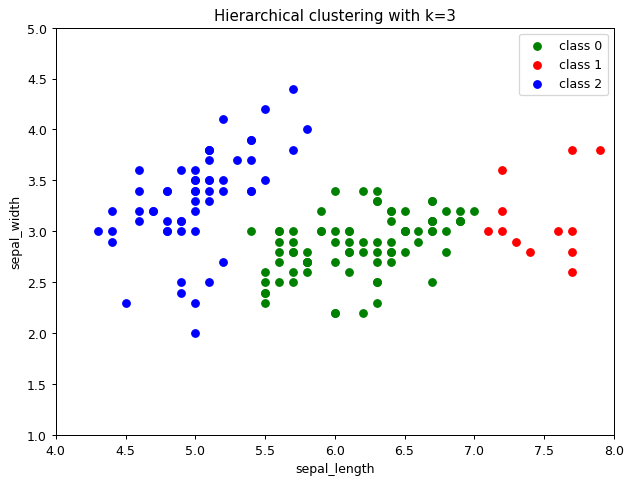

In [49]:
# 定义聚类数的节点
class ClusterNode:
  def __init__(self, vec, left=None, right=None, distance=-1, id=None, count=1):
    """
    :param vec: 保存两个数据聚类后形成新的中心
    :param left: 左节点
    :param right:  右节点
    :param distance: 两个节点的距离
    :param id: 用来标记哪些节点是计算过的
    :param count: 这个节点的叶子节点个数
    """
    self.vec = vec
    self.left = left
    self.right = right
    self.distance = distance
    self.id = id
    self.count = count
# -----------------------------------------------------------

def euler_distance(point1: np.ndarray, point2: list) -> float:
  """
  计算两点之间的欧拉距离，支持多维
  """
  distance = 0.0
  for a, b in zip(point1, point2):
    distance += math.pow(a - b, 2)
  return math.sqrt(distance)
# -----------------------------------------------------------     

# 层次聚类（聚合法）
class Hierarchical:
  def __init__(self, k):
    self.k = k
    self.labels = None

  def fit(self, x):
    nodes = [ClusterNode(vec=v, id=i) for i, v in enumerate(x)]
    distances = {}
    point_num, feature_num = x.shape
    self.labels = [-1] * point_num
    currentclustid = -1
    while(len(nodes)) > self.k:
      min_dist = math.inf
      nodes_len = len(nodes)
      closest_part = None
      for i in range(nodes_len - 1):
        for j in range(i+1, nodes_len):
            d_key = (nodes[i].id, nodes[j].id)
            if d_key not in distances:
              distances[d_key] = euler_distance(nodes[i].vec, nodes[j].vec)
            d = distances[d_key]
            if d < min_dist:
              min_dist = d
              closest_part = (i, j)

      part1, part2 = closest_part
      node1, node2 = nodes[part1], nodes[part2]
      new_vec = [ (node1.vec[i] * node1.count + node2.vec[i] * node2.count ) / (node1.count + node2.count) for i in range(feature_num)]
      new_node = ClusterNode(vec=new_vec, left=node1, right=node2, distance=min_dist, id=currentclustid, count=node1.count + node2.count)
      currentclustid -= 1
      del nodes[part2], nodes[part1]
      nodes.append(new_node)

    self.nodes = nodes
    self.calc_label()

  def calc_label(self):
    """
    调取聚类的结果
    """
    for i, node in enumerate(self.nodes):
      # 将节点的所有叶子节点都分类
      self.leaf_traversal(node, i)

  def leaf_traversal(self, node: ClusterNode, label):
    """
    递归遍历叶子节点
    """
    if node.left == None and node.right == None:
      self.labels[node.id] = label
    if node.left:
      self.leaf_traversal(node.left, label)
    if node.right:
      self.leaf_traversal(node.right, label)
# ------------------------------------------------

# TEST
Hierarchical = Hierarchical(3)
Hierarchical.fit(data)
labels = np.array(Hierarchical.labels)
print(labels)
print("---------------------------------------------")
# visualize result
cat1 = data[np.where(labels==0)]
cat2 = data[np.where(labels==1)]
cat3 = data[np.where(labels==2)]
plt.figure(figsize=(8, 6), dpi=90)
plt.scatter(cat1[:,0], cat1[:,1], color='green', label="class 0")
plt.scatter(cat2[:,0], cat2[:,1], color='red', label="class 1")
plt.scatter(cat3[:,0], cat3[:,1], color='blue', label="class 2")
plt.title('Hierarchical clustering with k=3')
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")
plt.xlim(4, 8)
plt.ylim(1, 5)
plt.legend()
plt.show()

## sklearn instance

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 2 0 2 0 1 0 1 1 0 2 0 2 0 2 2 2 2 0 0 2 0
 0 0 0 0 0 2 2 2 2 0 2 0 0 2 2 2 2 0 2 1 2 2 2 0 1 2 0 2 0 0 0 0 1 0 0 0 0
 0 0 2 2 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0
 0 0]
---------------------------------------------


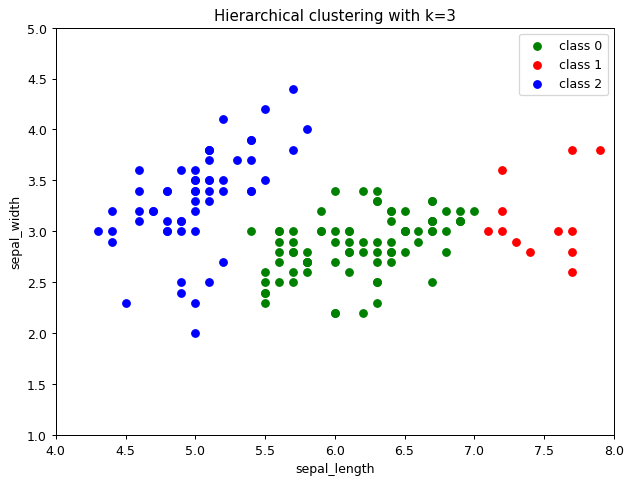

In [50]:
sk = cluster.AgglomerativeClustering(3)
sk.fit(data)
labels_ = sk.labels_
print(labels_)
print("---------------------------------------------")
# visualize result
cat1 = data[np.where(labels==0)]
cat2 = data[np.where(labels==1)]
cat3 = data[np.where(labels==2)]
plt.figure(figsize=(8, 6), dpi=90)
plt.scatter(cat1[:,0], cat1[:,1], color='green', label="class 0")
plt.scatter(cat2[:,0], cat2[:,1], color='red', label="class 1")
plt.scatter(cat3[:,0], cat3[:,1], color='blue', label="class 2")
plt.title('Hierarchical clustering with k=3')
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")
plt.xlim(4, 8)
plt.ylim(1, 5)
plt.legend()
plt.show()

[[6.81276596 3.07446809]
 [5.77358491 2.69245283]
 [5.006      3.428     ]]
-----------------------------------------------


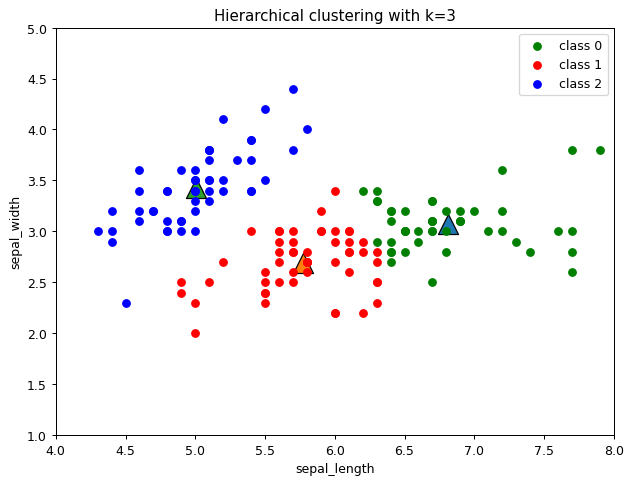

In [51]:
# the class of kmeans algorithm.
class MyKmeans:
  def __init__(self, k, n=20):
    self.k = k
    self.n = n

  def fit(self, x, centers=None):
    # 第一步，随机选择 K 个点, 或者指定
    if centers is None:
      idx = np.random.randint(low=0, high=len(x), size=self.k)
      centers = x[idx]
    inters = 0
    while inters < self.n:
      points_set = {key: [] for key in range(self.k)}
      # 第二步，遍历所有点 P，将 P 放入最近的聚类中心的集合中
      for p in x:
        nearest_index = np.argmin(np.sum((centers - p) ** 2, axis=1) ** 0.5)
        points_set[nearest_index].append(p)
      # 第三步，遍历每一个点集，计算新的聚类中心
      for i_k in range(self.k):
        centers[i_k] = sum(points_set[i_k])/len(points_set[i_k])
      inters += 1
    return points_set, centers

# -----------------------------------------------------
# TEST
k_means = MyKmeans(3)
points_set, centers = k_means.fit(data)
print(centers)
print("-----------------------------------------------")
# visualize result
cat1 = np.asarray(points_set[0])
cat2 = np.asarray(points_set[1])
cat3 = np.asarray(points_set[2])
plt.figure(figsize=(8, 6), dpi=90)
for ix, p in enumerate(centers):
  plt.scatter(p[0], p[1], color='C{}'.format(ix), marker='^', edgecolor='black', s=256)
        
plt.scatter(cat1[:,0], cat1[:,1], color='green', label="class 0")
plt.scatter(cat2[:,0], cat2[:,1], color='red', label="class 1")
plt.scatter(cat3[:,0], cat3[:,1], color='blue', label="class 2")
plt.title('Hierarchical clustering with k=3')
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")
plt.xlim(4, 8)
plt.ylim(1, 5)
plt.legend()
plt.show()

## sklearn instance

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 2 0 2 0 2 0 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2
 0 0 0 0 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 0 0 0 2 0 0 0 0
 0 0 2 2 0 0 0 0 2 0 2 0 2 0 0 2 2 0 0 0 0 0 2 2 0 0 0 2 0 0 0 2 0 0 0 2 0
 0 2]
-----------------------------------------------
[[6.81276596 3.07446809]
 [5.006      3.428     ]
 [5.77358491 2.69245283]]
-----------------------------------------------


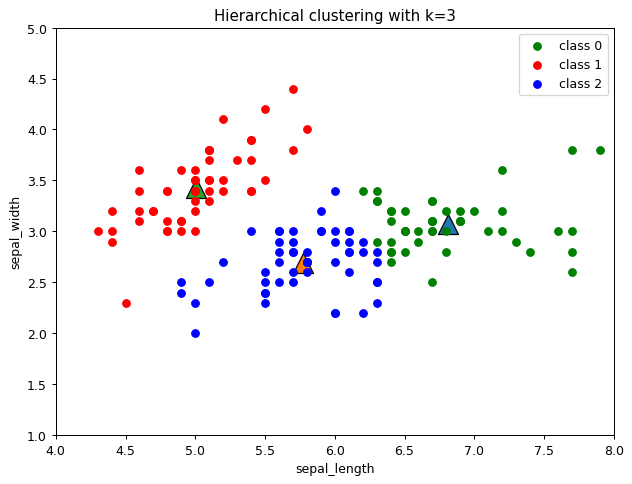

In [53]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, max_iter=100).fit(data)
print(kmeans.labels_)
print("-----------------------------------------------")
print(kmeans.cluster_centers_)
print("-----------------------------------------------")
# visualize result
cat1 = data[kmeans.labels_ == 0]
cat2 = data[kmeans.labels_ == 1]
cat3 = data[kmeans.labels_ == 2]

plt.figure(figsize=(8, 6), dpi=90)
for ix, p in enumerate(centers):
  plt.scatter(p[0], p[1], color='C{}'.format(ix), marker='^', edgecolor='black', s=256)
        
plt.scatter(cat1[:,0], cat1[:,1], color='green', label="class 0")
plt.scatter(cat2[:,0], cat2[:,1], color='red', label="class 1")
plt.scatter(cat3[:,0], cat3[:,1], color='blue', label="class 2")
plt.title('Hierarchical clustering with k=3')
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")
plt.xlim(4, 8)
plt.ylim(1, 5)
plt.legend()
plt.show()

## searching the best value of K

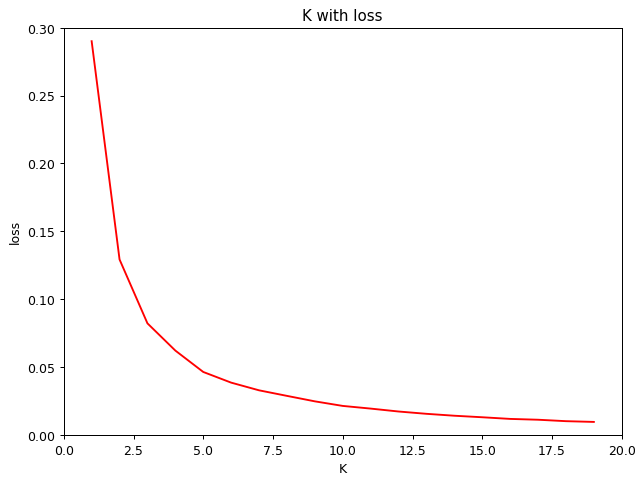

In [61]:
from sklearn.cluster import KMeans

loss = []
for i in range(1, 20):
  kmeans = KMeans(n_clusters=i, max_iter=1000).fit(data)
  loss.append(kmeans.inertia_ / len(data) / 3)
plt.figure(figsize=(8, 6), dpi=90)
plt.title('K with loss')
plt.xlabel("K")
plt.ylabel("loss")
plt.xlim(0, 20)
plt.ylim(0, 0.3)
plt.plot(range(1, 20), loss, color="red")
plt.show()